Dataset: https://drive.google.com/drive/folders/1dYYjeQDfl4_YFSXkquSrotLKI2f_9Whz?usp=drive_link

# Object Detection using FasterRCNN

## installs

In [2]:
!pip install pycocotools

## imports

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
import pandas as pd

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


## Set the Device

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset

### Define the transformations

1. Define Transformations for Training:

    * Apply augmentations such as resizing, horizontal and vertical flips, random brightness/contrast adjustments, and color jittering to the images during training.
    * Convert the images and bounding boxes to tensors using ToTensorV2.
    * Use `albumentations` library for augmentations instead of `torchvision`. (Nothing changes, you just need to use A.Compose, A.Resize etc instead of torchivision.transforms.Compose...)

PS. You need to use `bbox_params` parameter of `A.Compose()` method in order to make transformations compatible with our bounding box labels.

In [6]:
def get_transforms(train=False):

    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    return transform

### Define Custom Class for the Dataset

There should be 4 type of functions in the class:

1. `def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None)`

    * Initialize the dataset by providing the root directory where images and annotations are stored, along with the split ('train', 'valid', or 'test').
    * Load the COCO annotations using the `COCO()`.
    * Get the image IDs from the annotations.
2. `def _load_image(self, id)` & `def _load_target(self, id)`

    * Implement methods _load_image and _load_target to load images and their corresponding annotations.
    * Convert the loaded images from BGR to RGB format.
    * Load annotations for each image using the COCO API.
3. `def __getitem__(self, index)`

    * Implement the __getitem__ method to transform the images and annotations.
    * Use Albumentations library to apply transformations such as resizing and bounding box adjustments.
Convert bounding box coordinates from (x, y, w, h) format to (x1, y1, x2, y2) format.
    * Convert annotations into tensors with keys for boxes, labels, image IDs, areas, and crowd status.
4. `def __len__(self)`

    * Implement the __len__ method to return the total number of images in the dataset.

In [7]:
class AquariumDetection(datasets.VisionDataset):

    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # Initialize the VisionDataset superclass with necessary transformations
        super().__init__(root, transforms, transform, target_transform)

        # Set the dataset split (train, valid, test)
        self.split = split

        # Initialize COCO object for annotation handling
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))

        # Get list of image IDs and filter out images without annotations
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        # Load the image file name from the COCO dataset using the image ID
        path = self.coco.loadImgs(id)[0]['file_name']

        # Read the image from the file
        image = cv2.imread(os.path.join(self.root, self.split, path))

        # Convert the image from BGR to RGB color space
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        # Load the annotations for a given image ID
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        # Get the image ID corresponding to the given index
        id = self.ids[index]

        # Load the image and its annotations
        image = self._load_image(id)
        target = self._load_target(id)

        # Deep copy the target annotations to avoid side effects
        target = copy.deepcopy(self._load_target(id))

        # Extract bounding boxes and category IDs from annotations
        boxes = [t['bbox'] + [t['category_id']] for t in target]

        # Apply any transformations if specified
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

            # Get the transformed image and bounding boxes
            image = transformed['image']
            boxes = transformed['bboxes']

        # Convert bounding boxes from (x, y, w, h) to (xmin, ymin, xmax, ymax) format
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        # Convert the new bounding boxes to a tensor
        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        # Prepare the target dictionary with transformed annotations
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])

        # Calculate the area of each bounding box
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

        # Return the image (scaled to [0, 1]) and the target annotations
        return image.div(255), targ

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.ids)


### Load the dataset

1. Define the root directory for your dataset (ROOT) and the path to your dataset (dataset_path).

In [8]:
ROOT = "/content/drive/MyDrive/EE417/Labs/Week-12"
dataset_path = f"{ROOT}/Aquarium Combined/"

2. Load the COCO annotations from the training split and extracted the class names from them.

In [9]:
#load classes

coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=7.09s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

3. Create Datasets:

    * Create two datasets: train_dataset and test_dataset.
    * Each dataset is an instance of your custom AquariumDetection class.
    * For the training dataset, apply transformations suitable for training (`get_transforms(True)`).
    * For the test dataset, apply transformations suitable for inference (`get_transforms(False)`).

In [11]:
train_dataset = AquariumDetection(
    root=dataset_path,
    transforms=get_transforms(True)
    )

test_dataset = AquariumDetection(
    root=dataset_path,
    split="test",
    transforms=get_transforms(False)
    )

# val_dataset = AquariumDetection(
#     root=dataset_path,
#     split="valid",
#     transforms=get_transforms(False)
#     )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=14.82s)
creating index...
index created!


### Display a Sample

1. Load sample from training set
2. Convert the image tensor (sample[0]) to a NumPy array and scale it to the range [0, 255] using torch.tensor(sample[0] * 255, dtype=torch.uint8).
3. Use the draw_bounding_boxes function from torchvision.utils to draw bounding boxes and class labels on the image.
4. Display the annotated image using Matplotlib's plt.imshow function.


"\nIn PyTorch, tensors are commonly represented in a format where the dimensions correspond to\n(C, H, W) - Channels, Height, and Width respectively. However, many image processing libraries,\nincluding Matplotlib's plt.imshow(), expect the image data to be in (H, W, C) format -\nHeight, Width, and Channels. The permute function is used to rearrange the dimensions of the tensor.\n"

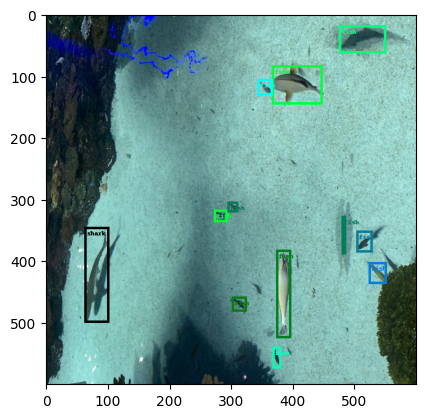

In [13]:
# Retrieve a sample from the training dataset at index 2
idx = 1

sample = train_dataset[idx]

# Convert the image tensor from [0, 1] range to [0, 255] range and cast to uint8
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

# Draw bounding boxes on the image
# 'draw_bounding_boxes' is assumed to be a function that draws bounding boxes on the image
# 'sample[1]['boxes']' contains the bounding boxes
# '[classes[i] for i in sample[1]['labels']]' converts label indices to class names
# 'width=4' specifies the width of the bounding box lines
# 'permute(1, 2, 0)' rearranges the dimensions of the image tensor for plotting with plt.imshow (HWC format)
plt.imshow(
    draw_bounding_boxes(
        img_int,
        sample[idx]['boxes'],
        [classes[i] for i in sample[idx]['labels']],
        width=4
).permute(1, 2, 0))


"""
In PyTorch, tensors are commonly represented in a format where the dimensions correspond to
(C, H, W) - Channels, Height, and Width respectively. However, many image processing libraries,
including Matplotlib's plt.imshow(), expect the image data to be in (H, W, C) format -
Height, Width, and Channels. The permute function is used to rearrange the dimensions of the tensor.
"""

In [14]:
len(train_dataset), len(test_dataset) # , len(val_dataset)

(447, 63)

### Dataloaders

1. Define Custom Collate Function:

    * Implement a collate function (collate_fn) that takes a batch of samples as input and returns a tuple of batches for images and targets.
    * This function helps in organizing the samples into batches during data loading.

    > **Note:** In object detection tasks, each sample typically consists of an image and its corresponding annotations (bounding boxes, labels, etc.). These annotations may vary in number for each image. When creating batches, we need to ensure that all samples within a batch have the same structure.

2. Set Batch Size:

    * Define the batch size (BATCH) indicating the number of samples in each batch.

3. Create Data Loaders:
    * Instantiate data loaders (train_loader and test_loader) using DataLoader from PyTorch's torch.utils.data module.
    * Specify the dataset (train_dataset and test_dataset), batch size, shuffle option, number of worker processes for data loading, and collate function.

In [15]:
def collate_fn(batch):
    # The `batch` parameter is a list of tuples, where each tuple contains (image, target)
    # Example: batch = [(image1, target1), (image2, target2), ...]

    # Use the unpacking operator `*` to unpack the list of tuples
    # and then `zip` them together. The `zip` function pairs up the first elements, the second elements, etc.
    # Example: zip(*batch) would transform [(image1, target1), (image2, target2)]
    # into [(image1, image2), (target1, target2)]
    zipped_batch = zip(*batch)

    # Convert the zipped result into a tuple
    # This separates images and targets into two tuples:
    # Example: ((image1, image2), (target1, target2))
    return tuple(zipped_batch)


In [16]:
BATCH = 4

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=True, num_workers=4, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=True, num_workers=4, collate_fn=collate_fn)

## Training

### Model

1. Get the Model:
    * Initialize a Faster R-CNN model with a ResNet-50 backbone pre-trained on COCO dataset from `torchvision.models.detection` module.
2. Retrieve the Number of Input Features:
    * Retrieve the number of input features for the existing classifier head.
    * These features represent the dimensionality of the feature representations used for class prediction.
3. Replace the Classifier Head of the Model:
    * Replace the pre-trained classifier head (`box_predictor`) with a new one (`FastRCNNPredictor`).
    * This replacement allows you to customize the classifier for your specific task.

In [ ]:
# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone and FPN (Feature Pyramid Network)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier head in the ROI (Region of Interest) heads
# This is the number of features that the last fully connected layer expects as input
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head (box_predictor) with a new one
# FastRCNNPredictor is a class that allows us to specify a new head with the desired number of classes
# `in_features` is the number of input features for the new head
# `n_classes` is the number of classes in your dataset (including background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)

#### Move model to device

In [ ]:
model = model.to(device)

### Optimizer

1. Parameter Selection:
    * Select the parameters of the model that require gradients (p.requires_grad) for optimization.
    * These parameters include weights and biases of the model's layers that will be updated during training.

2. Optimizer Initialization:
    * Initialize the optimizer using the selected parameters.
    * Use Stochastic Gradient Descent (SGD) optimizer with momentum 0.9 and weight decay 1e-4.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.01,
    momentum=0.9,
    nesterov=True,
    weight_decay=1e-4
    )

### LR Scheduler

Create a learning rate scheduler that decays the learning rate by a factor of gamma every step_size epochs.


> A learning rate scheduler is a tool in machine learning and deep learning training that adjusts the learning rate of the optimizer during the training process.



In [ ]:
# Create a learning rate scheduler that decays the learning rate by a factor of gamma every step_size epochs

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,  # The optimizer whose learning rate will be scheduled
    step_size=3,  # Number of epochs between each decay step
    gamma=0.1  # Multiplicative factor of learning rate decay
)

## Training

Now it's time to train your model!

Unlike the previous applications, we won't use criterion for loss calculation. Our model will calculate the losses once we give the images and targets during forward propagation.

There will be 5 types of lossess calculated:
1. Total Loss
    * **Definition:** The total loss is the sum of all individual loss components.
    * **Purpose:** It provides a single scalar value representing the overall performance of the model on the training data.
2. Classification Loss
    * **Definition:** Also known as the "loss_classifier", this component measures the accuracy of object class predictions.
    * **Purpose:** It penalizes incorrect class predictions and encourages the model to assign the correct class labels to detected objects.
3. Box Regression Loss
    * **Definition:** Also known as the "loss_box_reg", this component measures the accuracy of bounding box predictions.
    * **Purpose:** It penalizes deviations between predicted bounding box coordinates and ground truth bounding box coordinates. This encourages the model to accurately localize objects.
4. Region Proposal Network (RPN) Loss
    * **Definition:** Also known as the "loss_rpn_box_reg", this component is specific to models with an RPN component (like Faster R-CNN).
    * **Purpose:** It measures the accuracy of anchor box predictions generated by the RPN. Anchor boxes are proposed regions where objects might be located. This loss helps in refining the anchor box coordinates.
5. Objectness Loss
    * **Definition:** This component measures the confidence of anchor boxes in containing objects.
    * **Purpose:** It penalizes incorrect objectness predictions. Anchor boxes with high objectness scores are more likely to contain objects, while those with low scores are considered background.

> **NOTE:** In the context of training object detection models, such as Faster R-CNN, the model typically outputs a dictionary of losses. Each key in this dictionary corresponds to a different component of the total loss (e.g., classification loss, bounding box regression loss, etc.). The goal is to combine these individual losses into a single scalar value that can be used for backpropagation to update the model parameters.

In [ ]:
num_epochs = 10

In [ ]:
# Initialize lists to store overall losses and detailed loss dictionaries for each iteration
all_losses = []
all_losses_dict = []

# Loop over the number of epochs
for epoch in range(num_epochs):

    # Set the model to training mode
    model.train()
    i = 0  # Initialize the iteration counter

    # Loop over the training data loader to get batches of images and targets
    for images, targets in train_loader:

        # Move images to the specified device (e.g., GPU)
        images = list(image.to(device) for image in images)

        # Move targets to the specified device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute the loss dictionary by passing images and targets to the model
        loss_dict = model(images, targets)  # The model computes the loss automatically if targets are provided

        # Sum the losses for the overall loss value
        losses = sum(loss for loss in loss_dict.values())

        # Convert the loss dictionary to a simple format for logging
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}

        # Get the scalar value of the overall loss
        loss_value = losses.item()

        # Append the overall loss and detailed loss dictionary to their respective lists
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        # Zero the gradients to prevent accumulation
        optimizer.zero_grad()

        # Backpropagate the loss
        losses.backward()

        # Update the model parameters
        optimizer.step()

        # Print the loss every 100 iterations
        if i % 100 == 0:
            print(f"\t\tEpoch: {epoch}, Iteration: {i}, Loss: {losses.item()}")

        i += 1  # Increment the iteration counter

    # Step the learning rate scheduler at the end of each epoch
    lr_scheduler.step()

    # Convert the list of loss dictionaries to a DataFrame for easy averaging and printing
    all_losses_dict_df = pd.DataFrame(all_losses_dict)

    # Print the average losses for the epoch
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch,  # Current epoch number
        optimizer.param_groups[0]['lr'],  # Current learning rate
        np.mean(all_losses),  # Mean of overall losses
        all_losses_dict_df['loss_classifier'].mean(),  # Mean of classifier loss
        all_losses_dict_df['loss_box_reg'].mean(),  # Mean of box regression loss
        all_losses_dict_df['loss_rpn_box_reg'].mean(),  # Mean of RPN box regression loss
        all_losses_dict_df['loss_objectness'].mean()  # Mean of objectness loss
    ))


Epoch: 0, Iteration: 0, Loss: 0.3842181861400604
Epoch: 0, Iteration: 100, Loss: 0.921491265296936
Epoch 0, lr: 0.001000, loss: 0.618363, loss_classifier: 0.264431, loss_box: 0.271343, loss_rpn_box: 0.033672, loss_object: 0.048917
Epoch: 1, Iteration: 0, Loss: 0.34998321533203125
Epoch: 1, Iteration: 100, Loss: 0.7271634340286255
Epoch 1, lr: 0.001000, loss: 0.561862, loss_classifier: 0.234424, loss_box: 0.255788, loss_rpn_box: 0.031044, loss_object: 0.040606
Epoch: 2, Iteration: 0, Loss: 0.5234191417694092
Epoch: 2, Iteration: 100, Loss: 0.3139724135398865
Epoch 2, lr: 0.001000, loss: 0.527546, loss_classifier: 0.215505, loss_box: 0.247315, loss_rpn_box: 0.029304, loss_object: 0.035423
Epoch: 3, Iteration: 0, Loss: 0.33051159977912903
Epoch: 3, Iteration: 100, Loss: 0.31693223118782043
Epoch 3, lr: 0.000100, loss: 0.507872, loss_classifier: 0.204902, loss_box: 0.242210, loss_rpn_box: 0.028266, loss_object: 0.032495
Epoch: 4, Iteration: 0, Loss: 0.2193029671907425
Epoch: 4, Iteration: 

## Evaluation

In [ ]:
model.eval()
torch.cuda.empty_cache()

### Test the model with a single sample

In [ ]:
# Retrieve an image from the test dataset at index 5
img, _ = test_dataset[5]

# Convert the image tensor from [0, 1] range to [0, 255] range and cast to uint8
img_int = torch.tensor(img * 255, dtype=torch.uint8)

# Disable gradient computation for inference
with torch.no_grad():
    # Forward pass the image through the model and obtain predictions
    # Move the image to the specified device (e.g., GPU)
    prediction = model([img.to(device)])

    # Extract the first prediction (assuming only one image is passed at a time)
    pred = prediction[0]


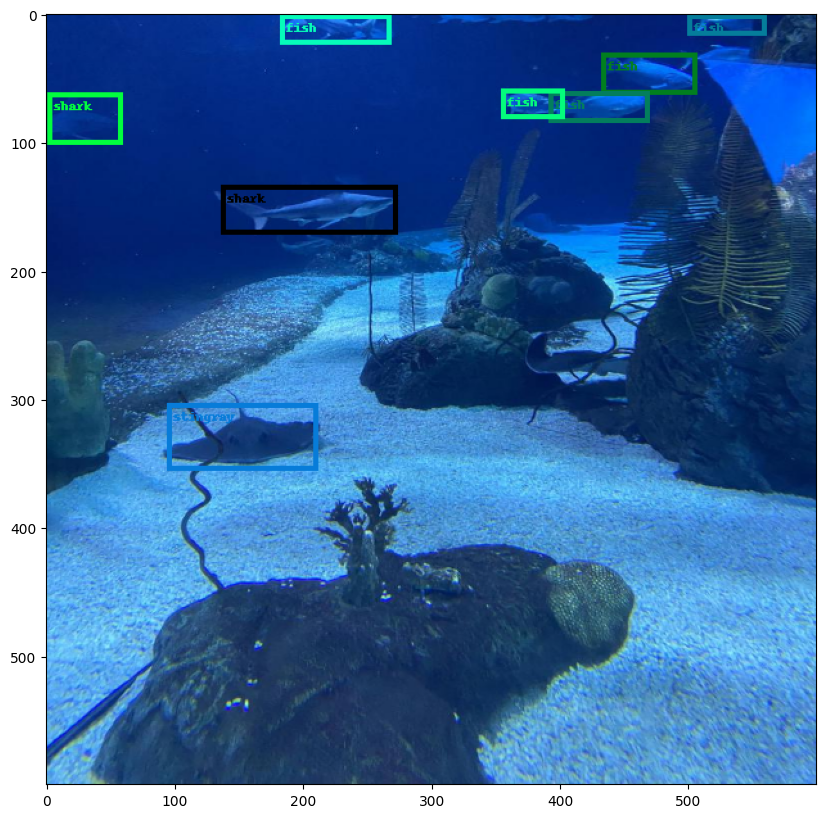

In [ ]:
# Create a new figure for plotting with a specific size
fig = plt.figure(figsize=(14, 10))

# Draw bounding boxes on the image using the 'draw_bounding_boxes' function
# The bounding boxes are filtered based on scores greater than 0.8
# 'pred['boxes'][pred['scores'] > 0.8]' selects bounding boxes with scores above 0.8
# '[classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()]' retrieves class names for the selected boxes
# 'width=4' specifies the width of the bounding box lines
# 'permute(1, 2, 0)' rearranges the dimensions of the image tensor for plotting with plt.imshow (HWC format)
plt.imshow(
    draw_bounding_boxes(
        img_int,
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],
        width=4
).permute(1, 2, 0))


# *Good luck with your finals!!*

![image](https://github.com/ultralytics/yolov5/assets/52993055/6ebd4dd7-31c5-4ed4-a2f4-e96a83429618)
